# Conv-model with Feature Engineering for Uncertainty Prediction

## Import packages

In [1]:
import glob
import os
import sys

sys.path.append('..')

In [2]:
import torch
import torch.nn as nn

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

from astropy.io import fits

from tqdm import tqdm

from inverse_problem import HinodeME
from inverse_problem import SpectrumDataset, PregenSpectrumDataset, make_loader
from inverse_problem.nn_inversion.posthoc import compute_metrics, open_param_file, plot_params, plot_pred_vs_refer, plot_analysis_hist2d
from inverse_problem.nn_inversion.posthoc import open_spectrum_data, real_spectra, plot_spectrum, plot_model_spectrum, read_spectrum_for_refer
from inverse_problem.nn_inversion.transforms import normalize_output, inverse_transformation

from inverse_problem.nn_inversion.model_pi_mlp_conv_up import PIMLPConvDistributionNet
from inverse_problem.nn_inversion import conv1d_transform_rescale, normalize_spectrum


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from datetime import datetime
from pathlib import Path

model_name = 'up_model'

current_time = str(datetime.now().strftime('%Y-%m-%d_%H-%M'))

save_path = '../' + model_name + '_' + current_time + '/'
Path(save_path).mkdir(parents=True, exist_ok=True)

save_path

'../up_model_2022-02-26_16-22/'

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device.type)

cpu


## Dataset

In [5]:
filename = '../data/parameters_base.fits'
transform = None
sobj = SpectrumDataset(param_path=filename, source='database', transform=transform)
sample = sobj[1]

In [ ]:
line_type = ['I', 'Q', 'U', 'V']
line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56)) - 6302.5
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
for i in range(4):
    ax[i // 2][i % 2].plot(line_arg, sample['X'][0][:, i])
    ax[i // 2][i % 2].set_title(f'Spectral line {line_type[i]}')
fig.set_tight_layout(tight=True)
fig.set_facecolor('xkcd:white')

## Data Filtering

In [7]:
params = fits.open(filename)[0].data

In [8]:
def params_masked_rows(pars_arr):
    
    max_par_values = np.array([par_arr.max() for par_arr in pars_arr.T])
    min_par_values = np.array([par_arr.min() for par_arr in pars_arr.T])

    bool_arr = (min_par_values + 1e-3 < pars_arr) & (pars_arr < max_par_values - 1e-3)
    return np.all(bool_arr, axis=1)

def create_masked_array(pars_arr):
    rows_mask = params_masked_rows(pars_arr)
    array_mask = rows_mask[:, np.newaxis] | np.zeros_like(pars_arr, dtype=bool)
    return ma.masked_array(pars_arr, mask=~array_mask)

In [9]:
rows_mask_params = params_masked_rows(params)
filtered_params = params[rows_mask_params, :]

## Dataloader

In [10]:
factors, cont_scale = [1, 1000, 1000, 1000], 40000
angle_transformation, logB = True, True

transform_name = "conv1d_transform_rescale"

batch_size = 128
# num_workers = 1 if 'cuda' in device.type else 0
num_workers = 0

In [11]:
train_loader, val_loader = make_loader(data_arr=filtered_params, transform_name=transform_name,
                                       factors=factors, cont_scale=cont_scale,
                                       logB=logB, angle_transformation=angle_transformation,
                                       batch_size=batch_size, num_workers=num_workers)

sample_batch = next(iter(train_loader))

print('Size of spectrum batch: ', sample_batch['X'][0].shape)
print('Size of cont batch: ', sample_batch['X'][1].shape)
print('Size of true params batch: ', sample_batch['Y'].shape)

print(f'\nNumber of batches for train: {len(train_loader)}, for validation: {len(val_loader)}')

Size of spectrum batch:  torch.Size([128, 4, 56])
Size of cont batch:  torch.Size([128, 1])
Size of true params batch:  torch.Size([128, 11])

Number of batches for train: 31243, for validation: 3472


## Model

In [12]:
model = PIMLPConvDistributionNet(n_blocks=6, in_dim=(4, 64, 64, 128, 128, 256), out_dim=(64, 64, 128, 128, 256, 256),
                                 kernel_size=(3, 3, 3, 3, 3, 3), padding=(1, 1, 1, 1, 1, 1), activation='elu', 
                                 dropout=0.05, batch_norm=True, pool=(None, 'max', None, 'max', None, None), 
                                 hidden_dims=(100, 100), bottom_output=100, number_readout_layers=2, top_output=11)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.to(device);

## Model Training

In [14]:
def mdn_cost(mu, sigma, y):
    dist = torch.distributions.Normal(mu, sigma)
    return torch.mean(-dist.log_prob(y))

def fit_step(dataloader, max_steps=None):
    train_loss = 0.0
    train_it = 0
    if max_steps is None:
        max_steps = float('inf')
    total = min(max_steps, len(dataloader))

    with tqdm(desc="batch", total=total, position=0, leave=True) as pbar_outer:
        for i, inputs in enumerate(dataloader):
            if i == total:
                break

            x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
            y = inputs['Y'].to(device)

            outputs = model(x)
            outputs_mean = outputs[:, :11]
            outputs_sigma = torch.exp(outputs[:, 11:])

            optimizer.zero_grad()
            
            losses = [mdn_cost(outputs_mean[:, ind], outputs_sigma[:, ind], y[:, ind])
                      for ind in range(11)]
            
            loss = torch.stack(losses).mean()
            loss.backward()
            
            optimizer.step()

            train_loss += loss.item()
            train_it += 1

            if train_it % 10 == 0:
                pbar_outer.update(10)

        return train_loss / train_it


def eval_step(dataloader):
    model.eval()
    val_loss = 0.0
    val_it = 0

    for i, inputs in enumerate(dataloader):
        x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
        y = inputs['Y'].to(device)

        with torch.no_grad():
            outputs = model(x)
            outputs_mean = outputs[:, :11]
            outputs_sigma = torch.exp(outputs[:, 11:])
            
            losses = [mdn_cost(outputs_mean[:, ind], outputs_sigma[:, ind], y[:, ind])
                      for ind in range(11)]
            
            loss = torch.stack(losses).mean()
            
            val_loss += loss.item()
            val_it += 1
    return val_loss / val_it


def save_model(path, epoch, loss):
    """
    Args:
        path (str): path to save model to
        epoch (int):
        loss (float): validation loss
    Returns:
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss},
        path + model_name + '_' + f'ep{epoch}.pt')


def train(n_epoch, log_dir=None, path_to_save=None, max_steps=None):
    loss_history = []
    best_valid_loss = float('inf')

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=n_epoch, position=0, leave=True) as pbar_outer:
        for epoch in range(n_epoch):
            train_loss = fit_step(train_loader)
            val_loss = eval_step(val_loader)
            loss_history.append((train_loss, val_loss))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss))

            if path_to_save:
                if val_loss < best_valid_loss:
                    best_valid_loss = val_loss
                    save_model(path_to_save, epoch, val_loss)

            with open(os.path.join(log_dir, 'history_' + model_name + '_' + current_time + '.txt'), 'w') as f:
                for i, item in enumerate(loss_history):
                    f.write(f"Train loss in epoch {i}: {item[0]: .4f}, val_loss: {item[1]:.4f}\n")

    return loss_history

In [15]:
num_epochs = 5

In [16]:
%%time

history = train(n_epoch=num_epochs,
                log_dir=save_path,
                path_to_save=save_path)

epoch:  20%|██        | 1/5 [2:20:58<9:23:53, 8458.31s/it]


Epoch 001 train_loss: -0.1460 val_loss -1.1015


epoch:  40%|████      | 2/5 [4:23:23<6:30:10, 7803.56s/it]


Epoch 002 train_loss: -2.3380 val_loss -2.4407


epoch:  60%|██████    | 3/5 [6:19:12<4:07:06, 7413.47s/it]


Epoch 003 train_loss: -2.4989 val_loss -2.5822


epoch:  80%|████████  | 4/5 [8:14:19<2:00:13, 7213.20s/it]


Epoch 004 train_loss: -2.5626 val_loss -2.4662


epoch: 100%|██████████| 5/5 [10:10:50<00:00, 7133.21s/it] 


Epoch 005 train_loss: -2.6080 val_loss -2.6618


epoch: 100%|██████████| 5/5 [10:10:51<00:00, 7330.30s/it]

CPU times: user 10h 5min 28s, sys: 15.9 s, total: 10h 5min 44s
Wall time: 10h 10min 51s


## Model Analysis

Два варианта:
- Оценка понимания моделью симуляции спектров из референсных значений, полученных обращением реальных спектров
- Оценка качество работы на реальных спектрах

In [17]:
checkpoint_path = save_path + 'up_model_ep4.pt'
model.load_state_dict(torch.load(checkpoint_path, map_location=device)['model_state_dict'])

<All keys matched successfully>

### Реферер
Посмотрим что он из себя представляет (на самом деле база с параметрами и есть композиция нескольких рефереров)

Несколько примеров лежат подготовленные на гугл диске:
https://drive.google.com/drive/folders/1bv-KLMI67kiGNxlOjkJha2UmVggjV-sa?usp=sharing

In [18]:
path_to_refer = '../data/hinode_source/20140926_170005.fits'

Можно с помощью функции сразу нормировать выходы так как это делается для сети, но посмотреть мы можем и сырые данные

In [19]:
refer_unnormalized, names = open_param_file(path_to_refer, normalize=False)
ref_unnormalized_2d = refer_unnormalized.reshape(-1, 11)

refer_shape = refer_unnormalized.shape

print('\n', refer_shape)

Open file with 36 available parameters, 11 will be selected
Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Source_Function
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift

 (512, 873, 11)


In [ ]:
plot_params(refer_unnormalized, names=names)

In [21]:
ref_2d = normalize_output(ref_unnormalized_2d.copy(),
                          logB=logB,
                          angle_transformation=angle_transformation)

refer = ref_2d.reshape(refer_shape).copy()

### Refer Filtering

In [22]:
masked_ref_2d = create_masked_array(ref_2d)
masked_ref = masked_ref_2d.reshape(refer.shape)

masked_ref_unnormalized_2d = create_masked_array(ref_unnormalized_2d)
masked_ref_unnormalized = masked_ref_unnormalized_2d.reshape(refer.shape)

### Тестируем модель на симуляции данных из реферера

тут нам препроцессинг может упростить PregenDataset, можно и руками с помощью  BatchMe приготовить данные (он там и есть). Дальше надо загрузить 500k параметров и сделать симуляцию, поэтому работает это долго (в SpectrumDataset генерация во время обучения, поэтому надо только считать параметры и это быстро)

In [23]:
%%time

transform = conv1d_transform_rescale(factors=factors, 
                                     angle_transformation=angle_transformation,
                                     cont_scale=cont_scale, logB=logB)

test_dataset = PregenSpectrumDataset(data_arr=masked_ref_unnormalized_2d,
                                     transform=transform)

CPU times: user 54.3 s, sys: 10.2 s, total: 1min 4s
Wall time: 1min 4s


In [24]:
inputs = test_dataset.samples
sim_x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
y = inputs['Y'].to(device)

In [25]:
%%time

model.eval()
with torch.no_grad():
    predicted = model(sim_x)

CPU times: user 1min 28s, sys: 38.3 s, total: 2min 6s
Wall time: 2min 7s


In [26]:
predicted_mean = predicted[:, :11].detach().cpu().numpy()
predicted_sigma = torch.exp(predicted[:, 11:]).detach().cpu().numpy()

In [27]:
fe_names = names.copy()
fe_names[0] = 'log(Field_Strength)'
fe_names[1] = 'cos(Field_Inclination)'
fe_names[2] = 'cos(Field_Azimuth)'

In [28]:
compute_metrics(masked_ref_2d.data, predicted_mean,
                names=fe_names,
                save_path=save_path+model_name+'.csv', 
                mask=masked_ref_2d.mask)

,r2,mse,mae
log(Field_Strength),0.9596,0.0006,0.0147
cos(Field_Inclination),0.9859,0.0010,0.0176
cos(Field_Azimuth),0.8355,0.0184,0.0626
Doppler_Width,0.9761,0.0004,0.0131
Damping,0.9680,0.0005,0.0137
Line_Strength,0.8821,0.0009,0.0136
Source_Function,0.9159,0.0003,0.0124
Source_Function_Gradient,0.9828,0.0001,0.0082
Doppler_Shift2,0.9736,0.0000,0.0036
Stray_Light_Fill_Factor,0.8857,0.0066,0.0530


In [ ]:
plot_pred_vs_refer(predicted_mean, refer, output_index=0)

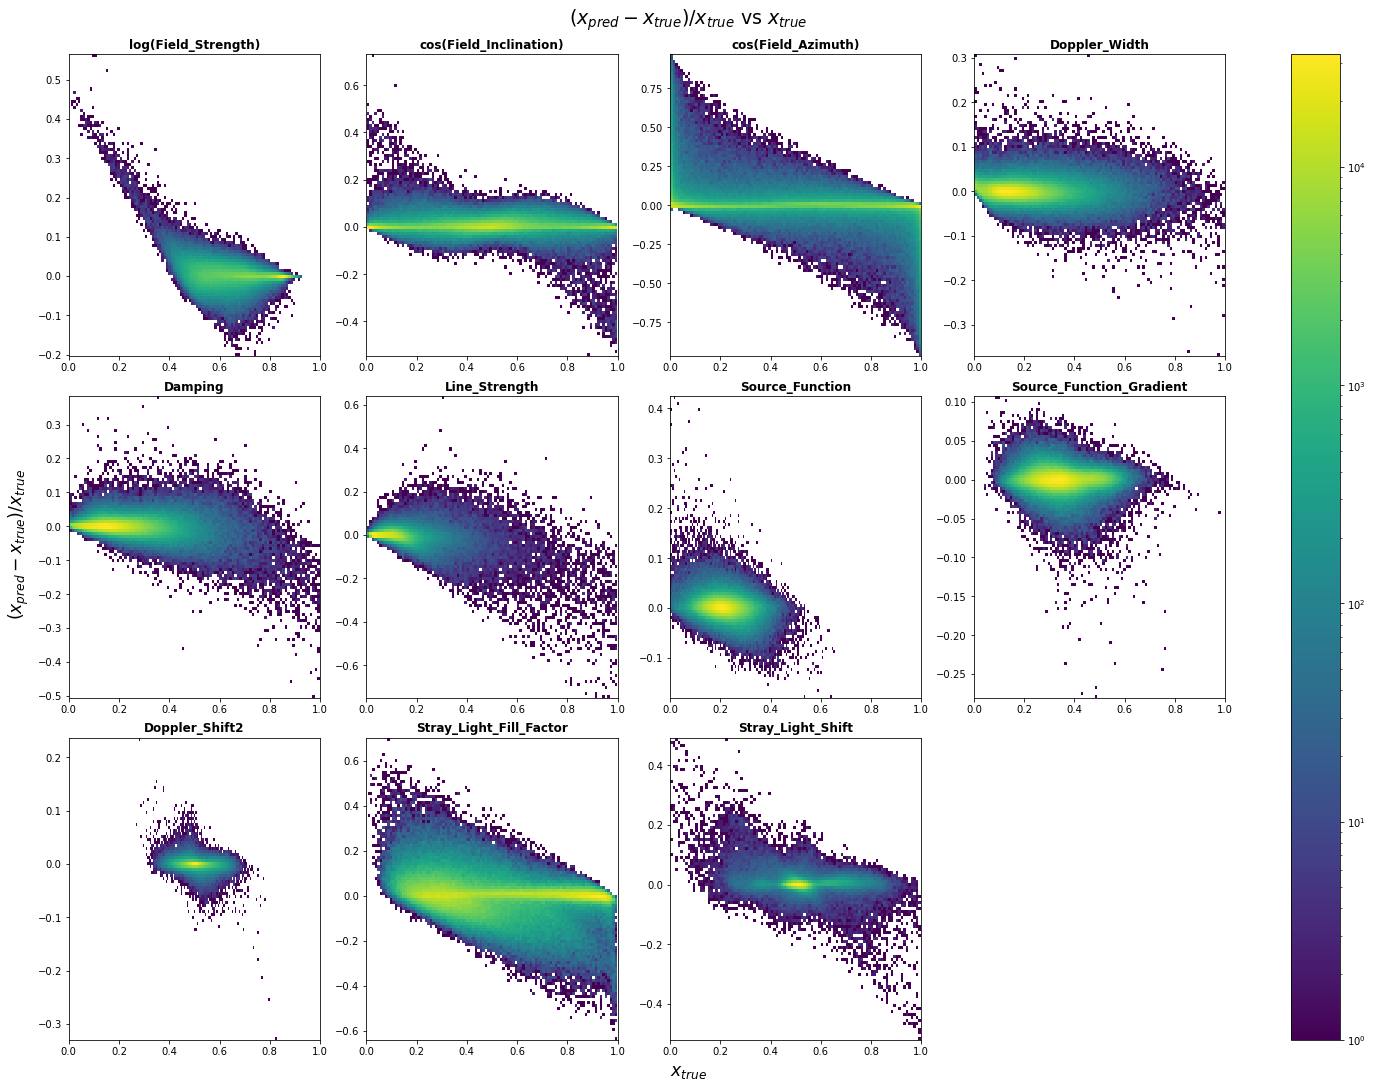

In [30]:
fig, axs = plot_analysis_hist2d(masked_ref_2d.data, predicted_mean, 
                                names=fe_names,
                                mask=masked_ref_2d.mask,
                                save_path=save_path+model_name+'_analysis_hist2d')

custom_xlim = (0, 1)
# custom_ylim = (-1, 1)
# plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)
plt.setp(axs, xlim=custom_xlim)

plt.show()

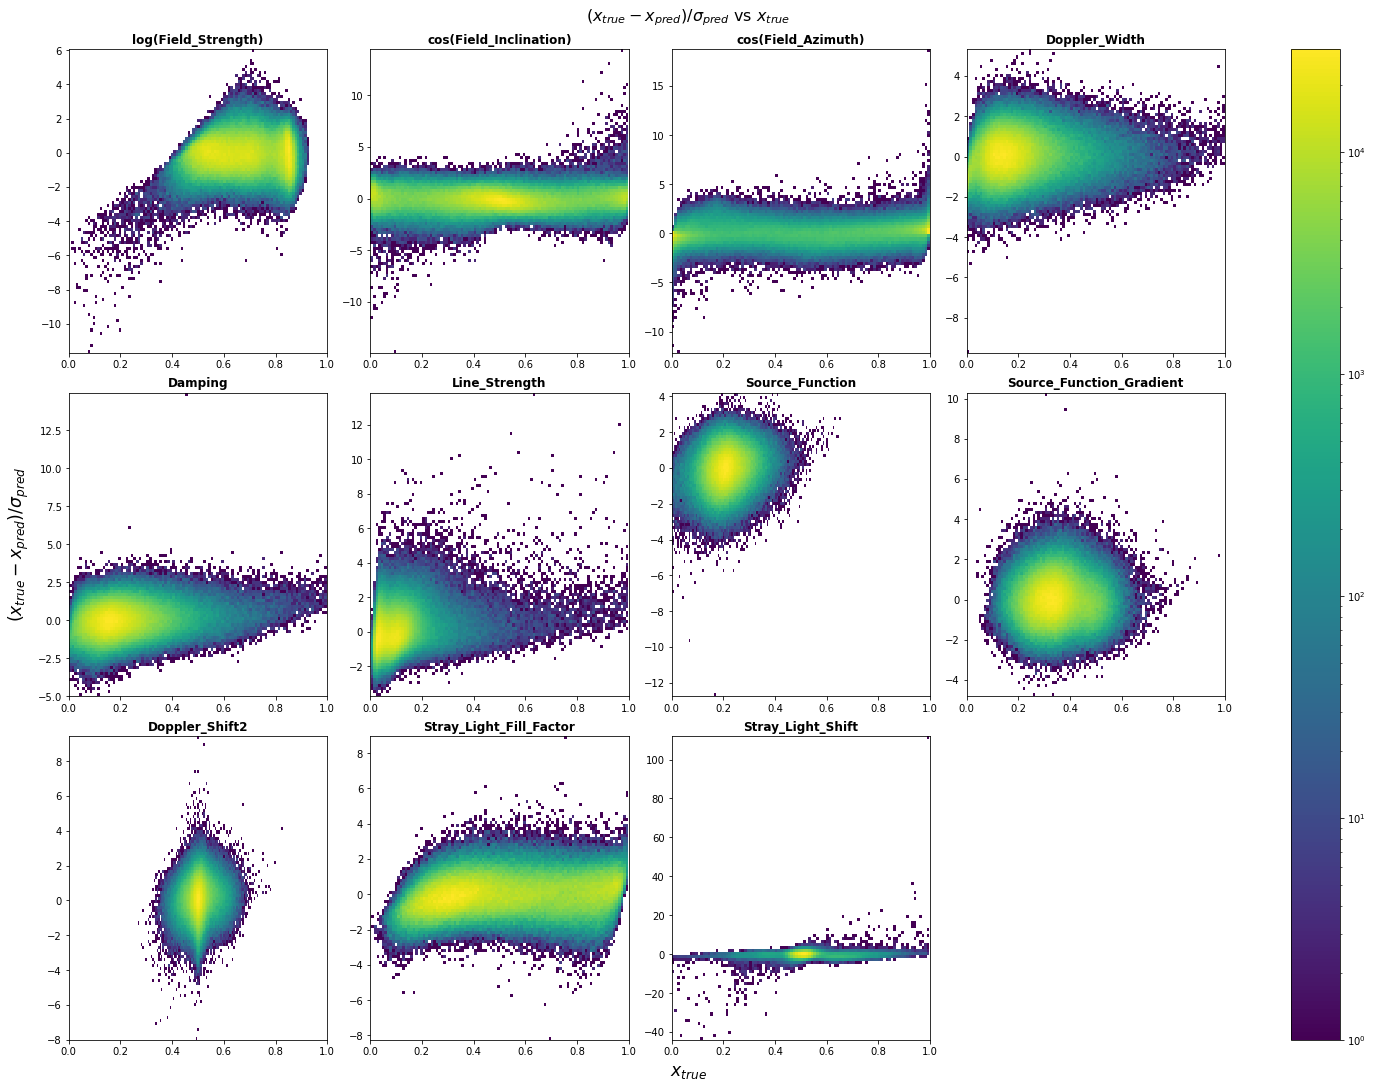

In [31]:
from inverse_problem.nn_inversion.posthoc import plot_analysis_hist2d_up

fig, axs = plot_analysis_hist2d_up(masked_ref_2d.data, predicted_mean, predicted_sigma,
                                   names=fe_names,
                                   index=0, 
                                   mask=masked_ref_2d.mask,
                                   save_path=save_path+model_name+'_analysis_hist2d_up1')

custom_xlim = (0, 1)
# custom_ylim = (-1, 1)
# plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)
plt.setp(axs, xlim=custom_xlim)

plt.show()

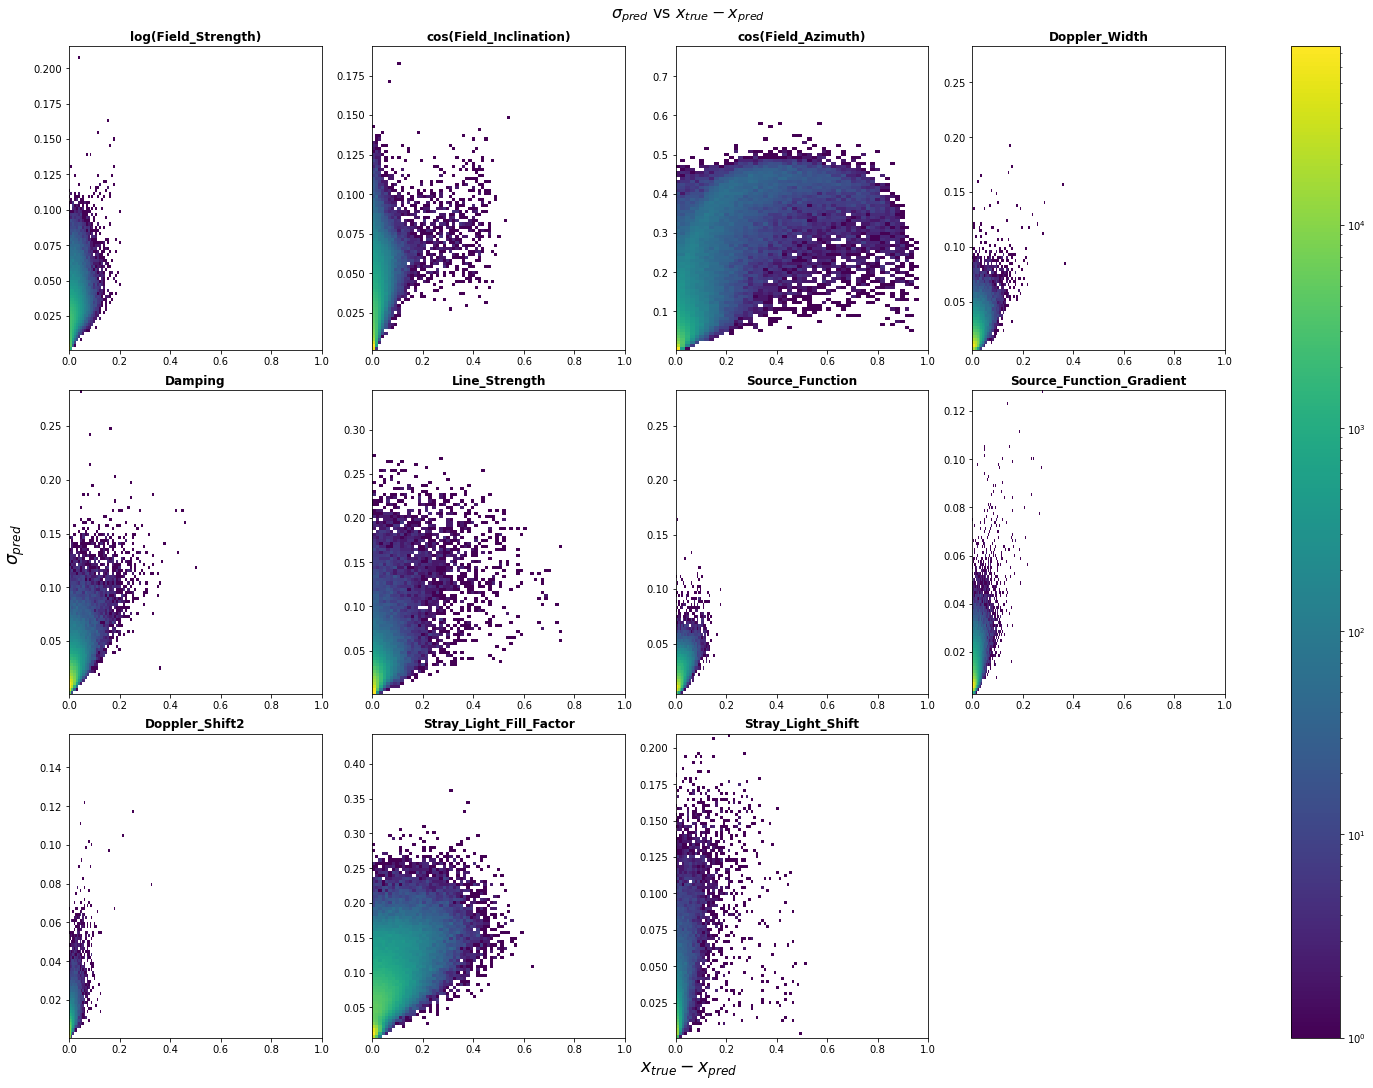

In [32]:
fig, axs = plot_analysis_hist2d_up(masked_ref_2d.data, predicted_mean, predicted_sigma,
                                   names=fe_names,
                                   index=1, 
                                   mask=masked_ref_2d.mask,
                                   save_path=save_path+model_name+'_analysis_hist2d_up2')

custom_xlim = (0, 1)
# custom_ylim = (-1, 1)
# plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)
plt.setp(axs, xlim=custom_xlim)

plt.show()

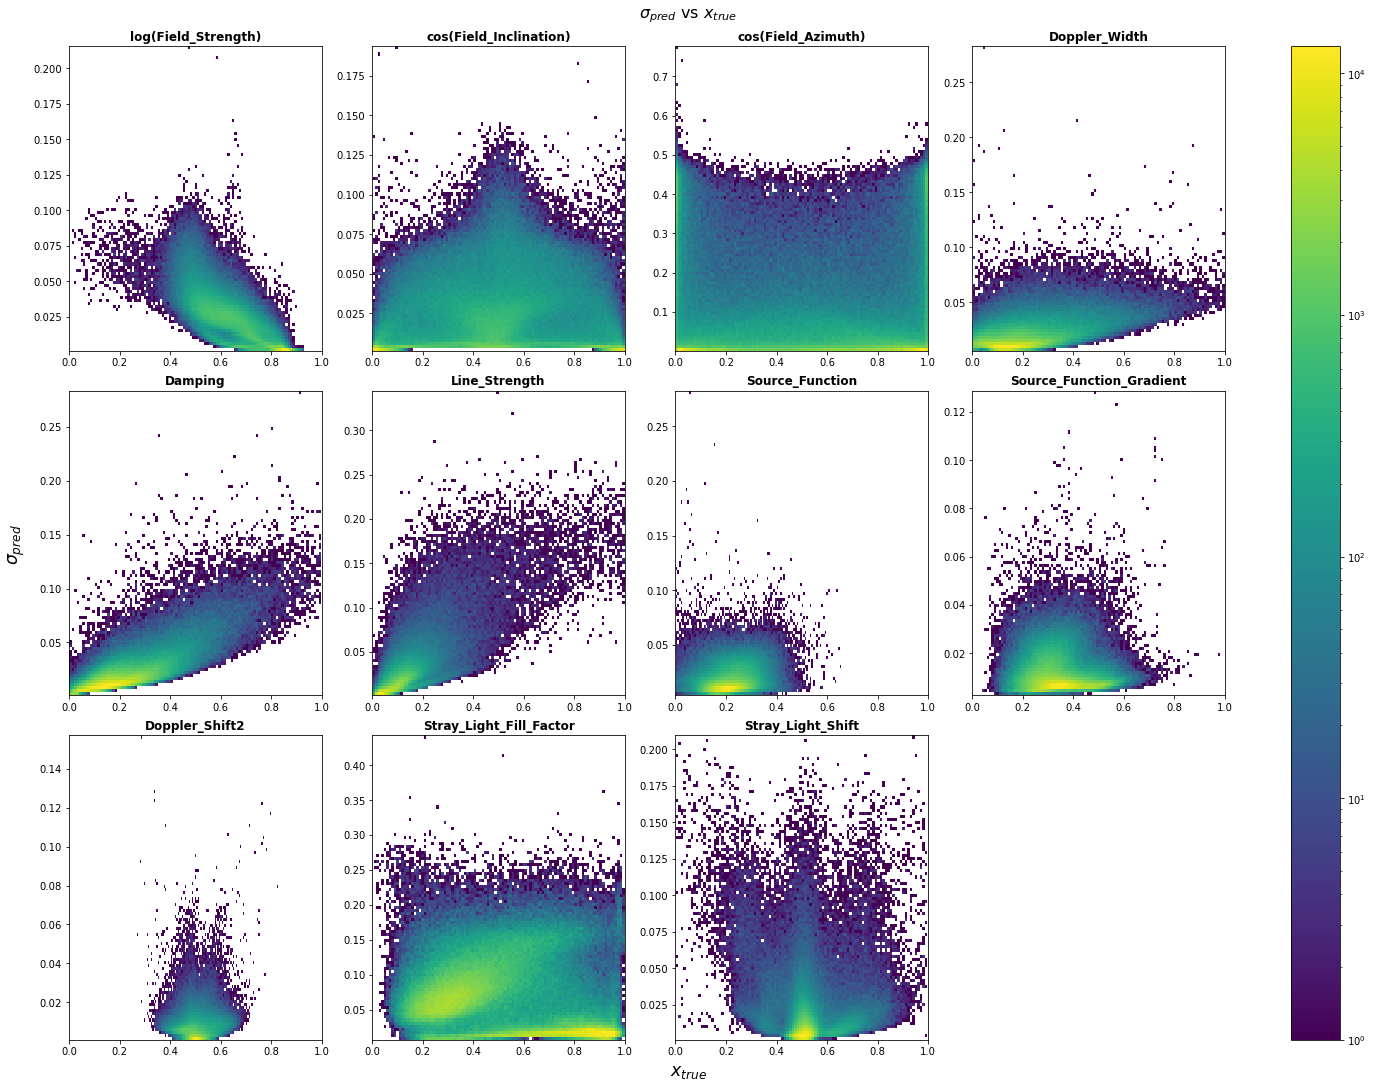

In [33]:
fig, axs = plot_analysis_hist2d_up(masked_ref_2d.data, predicted_mean, predicted_sigma,
                                   names=fe_names,
                                   index=2, 
                                   mask=masked_ref_2d.mask,
                                   save_path=save_path+model_name+'_analysis_hist2d_up3')

custom_xlim = (0, 1)
# custom_ylim = (-1, 1)
# plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)
plt.setp(axs, xlim=custom_xlim)

plt.show()

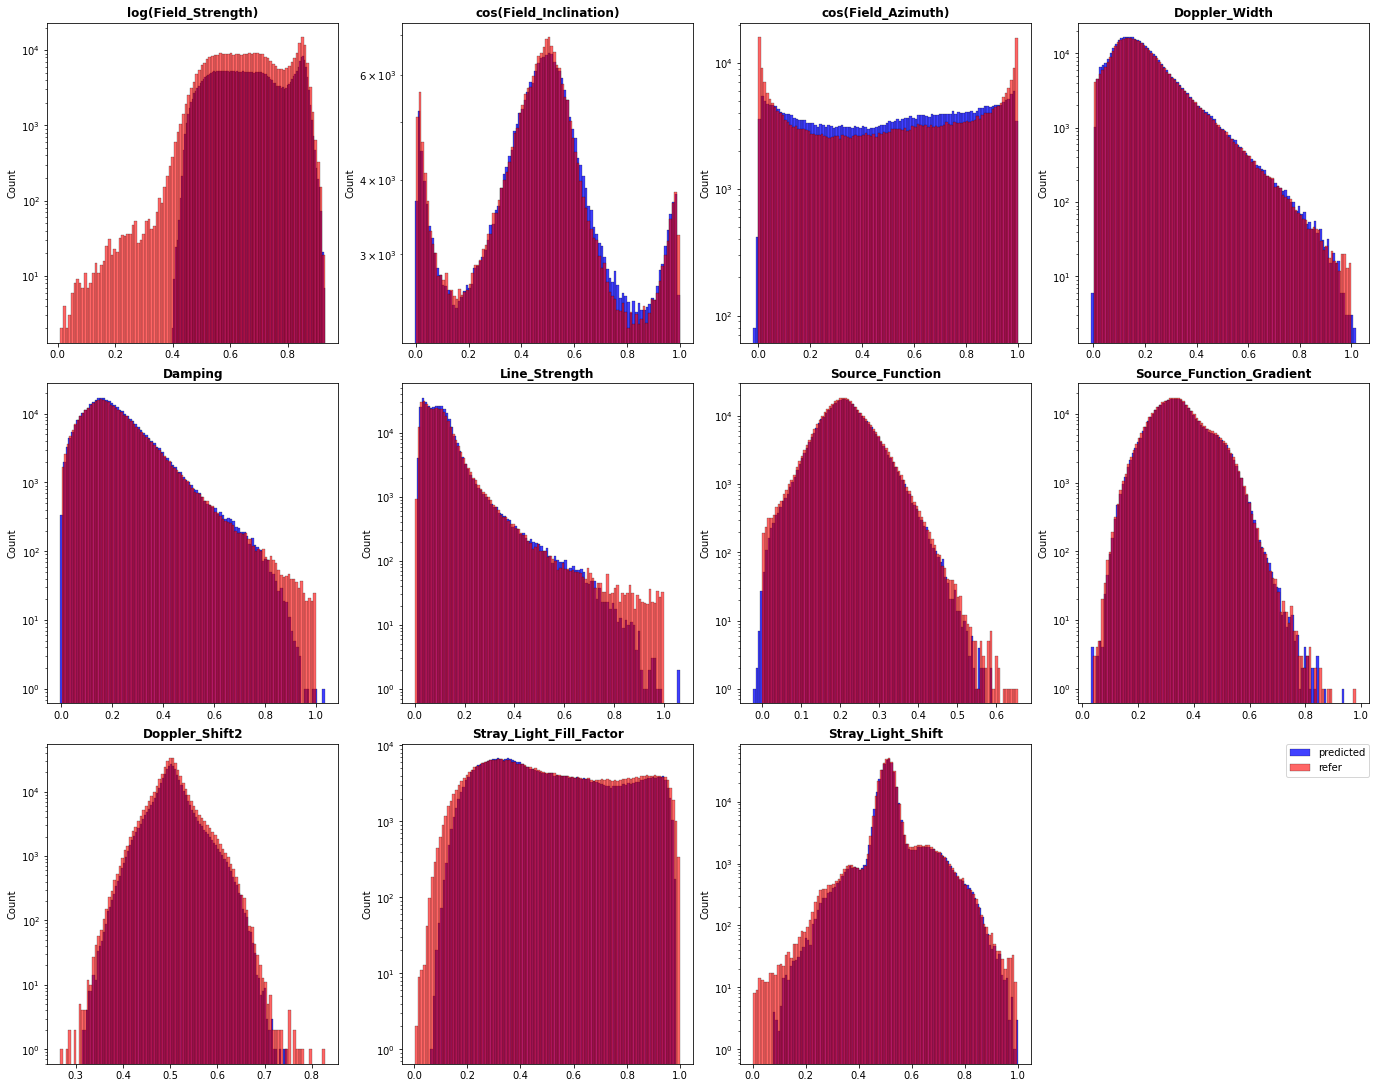

In [34]:
from inverse_problem.nn_inversion.posthoc import plot_hist_params_comparison

plot_hist_params_comparison(predicted_mean, masked_ref_2d.data, 
                            pars_names=fe_names,
                            mask=masked_ref_2d.mask,
                            save_path=save_path+model_name+'_comp_plot')
plt.show()

## Обратные преобразования параметров

In [38]:
broken_rows = np.any((predicted_mean[:, [1,2]] > 1) + (predicted_mean[:, [1,2]] < 0), axis=1)
sum(broken_rows)

552

In [39]:
mask_range = broken_rows[:, np.newaxis] | np.zeros_like(predicted_mean, dtype=bool)
combined_mask = mask_range + masked_ref_2d.mask

predicted_mean_prep = predicted_mean.copy()

predicted_mean_prep[:, 1:3] = np.clip(predicted_mean_prep[:, 1:3], 0, 1)

In [40]:
predicted_mean_inv = inverse_transformation(predicted_mean_prep,
                                            inv_logB=logB,
                                            inv_angle_transformation=angle_transformation)

In [42]:
compute_metrics(masked_ref_unnormalized_2d.data, predicted_mean_inv, 
                mask=combined_mask,
                save_path=save_path+model_name+'_inv' + '.csv')

,r2,mse,mae
Field Strength,0.9912,2137.1814,30.0717
Field Inclination,0.9853,19.6736,2.4404
Field Azimuth,0.8088,440.8730,9.9507
Doppler Width,0.9761,1.8314,0.9144
Damping,0.9680,0.0011,0.0205
Line Strength,0.8820,8.7215,1.3645
S_0,0.9159,508345.7507,480.0069
S_1,0.9828,530667.4269,493.8801
Doppler Shift,0.9736,0.0176,0.0712
Filling Factor,0.8854,0.0066,0.0531


In [ ]:
plot_analysis_hist2d(masked_ref_unnormalized_2d.data, predicted_mean_inv, 
                     mask=combined_mask, 
                     save_path=save_path+model_name+'_analysis_hist2d_inv')

plt.show()

In [ ]:
plot_hist_params_comparison(predicted_mean_inv, masked_ref_unnormalized_2d.data, 
                            mask=masked_ref_2d.mask,
                            save_path=save_path+model_name+'_inv_comp_plot')
plt.show()